<a href="https://colab.research.google.com/github/said-mk/ML-Projects/blob/main/FashionMNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torch import nn
from torchvision import datasets,transforms
from torch.utils.data.dataloader import DataLoader
from torch.nn import functional as F
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
device

device(type='cuda')

In [3]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    transform=transforms.ToTensor(),
    download=True

)

test_data = datasets.FashionMNIST(
    root='data',
    download=True,
    train=False,
    transform=transforms.ToTensor()
)

In [4]:
train_loader = DataLoader(
    dataset=train_data,
    batch_size= 64,
    pin_memory=True,
    num_workers=4,

)

test_loader = DataLoader(
    dataset=test_data,
    pin_memory=True,
    batch_size=64,
    num_workers=4,
)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [21]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}

In [60]:
class FashionMNISTNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1,32,3,1)
    self.conv2 = nn.Conv2d(32,64,3,1)
    self.conv3 = nn.Conv2d(64,128,3,1)
    self.dropout = nn.Dropout(0.25)
    self.fc1 = nn.Linear(61952,128)
    self.fc2 = nn.Linear(128,10)
    self.flatten = nn.Flatten()

  def forward(self,x):
    # conv1
    x = self.conv1(x)
    x = F.relu(x)
    x = self.dropout(x)

    # conv2
    x = self.conv2(x)
    x = F.relu(x)
    x = self.dropout(x)

    #conv3
    x = self.conv3(x)
    x = F.relu(x)
    x = self.dropout(x)

    # dense
    x = self.flatten(x)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.dropout(x)


    #logits
    output = self.fc2(x)

    return output

model = FashionMNISTNet().to(device)

In [6]:
def train_loop(model,dataloader,optimizer,loss_fn,device=device):
  size = len(dataloader.dataset)
  model.train()

  for batch_idx , (X,y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    # predictions
    prediction = model(X)
    loss = loss_fn(prediction, y)

    #backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    if batch_idx % 100 == 0:
      loss = loss.item()
      current = batch_idx * batch_size + len(X)
      print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [11]:
def test_loop(model,dataloader,loss_fn,device=device):
  model.eval()
  total_sample = len(dataloader.dataset)
  num_batches = len(dataloader)
  test_loss = 0
  correct_pred = 0

  with torch.no_grad():
    for X,y in dataloader:
      X, y = X.to(device), y.to(device)

      prediction = model(X)
      loss = loss_fn(prediction,y)

      test_loss += loss.item()
      # Accumulate loss (weighted by batch size for accurate average)
      # test_loss += loss.item() * data.size(0)
      correct_pred += (prediction.argmax(1) == y).type(torch.float).sum().item()

    test_loss = test_loss/num_batches
    correct_pred = correct_pred/total_sample

    print(f"Test Error: \n Accuracy: {(100*correct_pred):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [22]:
def visualize_test_samples(model, dataloader, device, num_images=5):
    model.eval()

    try:
        data_iter = iter(dataloader)
        images, targets = next(data_iter)
    except StopIteration:
        print("Error: DataLoader is empty or finished.")
        return

    if num_images > 12:
      print("Max number of image = 12")
      print("Maximun number images exceed!")
      print("Images reduced to 12.")
      num_images = 12

    images = images.to(device)

    # Predictions
    with torch.no_grad():
        logits = model(images)
        # Get the predicted class index
        predictions = logits.argmax(1).cpu().numpy()

    # Move original data to CPU for plotting
    images_cpu = images.cpu().numpy()
    targets_cpu = targets.cpu().numpy()


    plot_count = num_images
    fig, axes = plt.subplots(1, plot_count, figsize=(15, 3.5))

    print(f"\nDisplaying {plot_count} predictions:")

    if num_images == 1: # Error Handling:
      axes = [axes]     # TypeError: 'Axes' object is not subscriptable
    for i in range(plot_count):
        image = images_cpu[i].squeeze()

        true_label = targets_cpu[i]
        predicted_label = predictions[i]

        # Set color and text for visualization
        color = 'green' if true_label == predicted_label else 'red'

        # Plot the image
        axes[i].imshow(image, cmap='gray')

        # Predicted Label
        axes[i].set_title(f"Predicted: {labels_map[predicted_label]}", color=color, fontsize=10)

        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

In [61]:
learning_rate = 1e-3
batch_size = 64
epochs = 10
# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [62]:
for epoch in range(epochs):
  print(f"Epoch {epoch+1}\n-------------------------------")
  train_loop(model,train_loader,optimizer,loss_fn,device)
  test_loop(model,test_loader,loss_fn,device)
print("Done!")

Epoch 1
-------------------------------
loss: 2.296382  [   64/60000]
loss: 2.298069  [ 6464/60000]
loss: 2.293840  [12864/60000]
loss: 2.292051  [19264/60000]
loss: 2.290585  [25664/60000]
loss: 2.282468  [32064/60000]
loss: 2.274688  [38464/60000]
loss: 2.248955  [44864/60000]
loss: 2.225036  [51264/60000]
loss: 2.192649  [57664/60000]
Test Error: 
 Accuracy: 45.0%, Avg loss: 2.143988 

Epoch 2
-------------------------------
loss: 2.182851  [   64/60000]
loss: 2.068165  [ 6464/60000]
loss: 1.851214  [12864/60000]
loss: 1.639346  [19264/60000]
loss: 1.184388  [25664/60000]
loss: 1.070787  [32064/60000]
loss: 1.010233  [38464/60000]
loss: 0.912414  [44864/60000]
loss: 0.932089  [51264/60000]
loss: 0.870784  [57664/60000]
Test Error: 
 Accuracy: 72.2%, Avg loss: 0.766642 

Epoch 3
-------------------------------
loss: 0.760366  [   64/60000]
loss: 0.833516  [ 6464/60000]
loss: 0.567856  [12864/60000]
loss: 0.921226  [19264/60000]
loss: 0.748240  [25664/60000]
loss: 0.773315  [32064/600


Displaying 3 predictions:


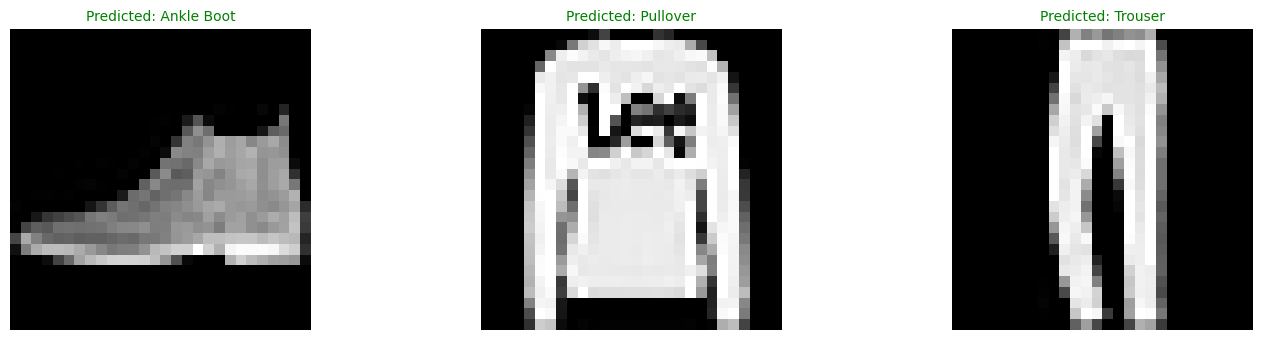

In [77]:
num_images = torch.randint(1,10,[1]).item()

visualize_test_samples(model, test_loader, device, num_images=num_images)